# Demo of 3D Segmentation with UNet

In [1]:
pip install monai

Note: you may need to restart the kernel to use updated packages.


## Setup environment

In [2]:
import monai
import matplotlib
%matplotlib inline

/home/lhb/anaconda3/envs/maeve/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup imports

In [16]:
import glob
import logging
import os
import time
import matplotlib.pyplot as plt

import nibabel as nib
import numpy as np
from monai.config import print_config
from monai.data import ArrayDataset, create_test_image_3d, decollate_batch, DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet, AttentionUnet
from monai.transforms import (
    Compose,
    LoadImage,
    EnsureChannelFirst,
    NormalizeIntensity,
    Activations,
    AsDiscrete,
)
from monai.utils import first, set_determinism
import torch

print_config()

MONAI version: 1.3.0
Numpy version: 1.24.3
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/envs/maeve/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.21.0
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.13.1
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For 

## Set deterministic training for reproducibility

In [5]:
set_determinism(seed=0)

## Setup data directory

In [4]:
root_dir = "/home/lhb/Desktop/Homework/data"
print(root_dir)

/home/lhb/Desktop/Homework/data


## Setup logging

In [5]:
log_file = os.path.join(root_dir, "demo.log")
logging.basicConfig(filename=log_file, level=logging.INFO, format="%(asctime)s -  %(message)s")
logger = logging.getLogger()

## Setup demo data

In [6]:
for i in range(40):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes=1)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"im{i}.nii.gz"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i}.nii.gz"))

images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
segs = sorted(glob.glob(os.path.join(root_dir, "seg*.nii.gz")))

## Setup transforms, dataset

In [9]:
# Define transforms for image and segmentation
train_imtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        NormalizeIntensity(nonzero=True, channel_wise=True),
    ]
)
train_segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
    ]
)
val_imtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        NormalizeIntensity(nonzero=True, channel_wise=True),
    ]
)
val_segtrans = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
    ]
)

# Define nifti dataset, dataloader
train_ds = ArrayDataset(images[:30], train_imtrans, segs[:30], train_segtrans)
train_loader = DataLoader(train_ds, batch_size=5, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())
val_ds = ArrayDataset(images[30:], val_imtrans, segs[30:], val_segtrans)
val_loader = DataLoader(val_ds, batch_size=5, num_workers=2, pin_memory=torch.cuda.is_available())

# Check data shape and visualize
print(torch.cuda.is_available())
im, seg = first(train_loader)
print(im.shape, seg.shape)

True
torch.Size([5, 1, 128, 128, 128]) torch.Size([5, 1, 128, 128, 128])


## Check data shape and visualize

<function matplotlib.pyplot.show(close=None, block=None)>

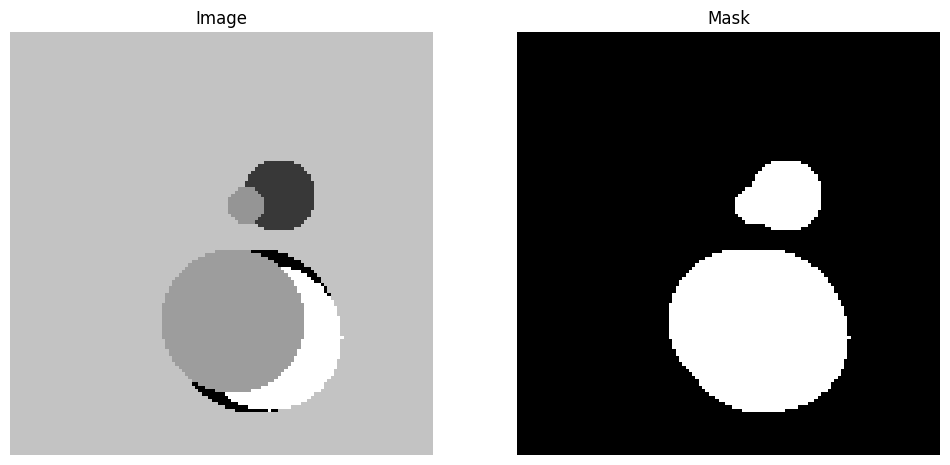

In [10]:
fig = plt.figure("Example image and mask for training", (12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Image")
ax1.imshow(im[0,0,:, :, 60].detach().cpu(), cmap="gray")
ax1.axis('off')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Mask")
ax2.imshow(seg[0,0,:, :, 60].detach().cpu(), cmap="gray")
ax2.axis('off')
plt.savefig(os.path.join(root_dir, "image_mask.tif"))
plt.show

## AttentionUNet

- __Attention Unet based on Otkay et al. “Attention U-Net: Learning Where to Look for the Pancreas” https://arxiv.org/abs/1804.03999 (Published in 2018 MIDL)__

<!-- ![AttentionUNet](1.png) -->
<img src="1.png" width="600"/>


- Borrowed the idea of an attention mechanism from NLP and used it in skip connections
     - skip connection에게 어떤 region에 focus를 해야할 지에 대한 추가적인 정보를 줌
- Works well even with very small objects due to the attention present in the skip connections


- As the same as U-Net or 3D U-Net, there is a contraction path at the left and expansion path at the right.
    - __Contraction path__: A series of conv and max pooling to extract local features.
    - __Expansion path__: A series of upsampling and conv for global feature.
        - And there are concatenation of feature maps at the same level using skip connection.
- But different from U-Net (same as 3D U-Net), 3D conv is used because the input image is 3D CT image.
- Another difference is that at the skip connection, there is an Attention Gate (AG) at each level.
    - __Attention Gate (AG)__
        - Voxel wise mask
        - After sigmoid, it goes through the resampler 
            - which is actually the trilinear interpolation
            - make the feature map sizes the same as the one to be element-multiplied
        - Finally, concatenation is performed with the upsampled feature maps at the lower level
        
        
- __Attention U-Net got 81.48 ± 6.23 on CT-82, which has better or comparative results with other SOTA approaches.__

## Create Model, Loss, Optimizer

In [17]:
max_epochs = 100
val_interval = 1
lr = 1e-4

# Create AttentionUNet, DiceLoss and Adam optimizer
device = torch.device("cuda")
# device = torch.device("mps")
# device = torch.device("cpu")
model = AttentionUnet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
).to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")

post_pred = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
post_label = Compose([AsDiscrete(threshold=0.5)])
    
# Use AMP to accelerate training
if torch.cuda.is_available():
    scaler = torch.cuda.amp.GradScaler()

## Execute a typical PyTorch training process

In [18]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
epoch_metric_values = []
metric_values = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        im, seg = batch_data
        inputs, labels = (
            im.to(device),
            seg.to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        if torch.cuda.is_available():
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    logger.info(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    outputs = [post_pred(i) for i in decollate_batch(outputs)]
    labels = [post_label(i) for i in decollate_batch(labels)]
    dice_metric(y_pred=outputs, y=labels)
    metric = dice_metric.aggregate().item()
    epoch_metric_values.append(metric)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                im, seg = val_data
                val_inputs, val_labels = (
                    im.to(device),
                    seg.to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            logger.info(f"epoch {epoch + 1} mean dice: {metric:.4f}")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")

----------
epoch 1/100
1/6, train_loss: 0.6166, step time: 1.2694
2/6, train_loss: 0.5362, step time: 1.1628
3/6, train_loss: 0.5583, step time: 1.1920
4/6, train_loss: 0.5413, step time: 1.1882
5/6, train_loss: 0.5079, step time: 1.1755
6/6, train_loss: 0.4691, step time: 1.2194
epoch 1 average loss: 0.5382
saved new best metric model
current epoch: 1 current mean dice: 0.4697
best mean dice: 0.4697 at epoch: 1
time consuming of epoch 1 is: 10.4461
----------
epoch 2/100
1/6, train_loss: 0.5399, step time: 1.1964
2/6, train_loss: 0.4361, step time: 1.1668
3/6, train_loss: 0.4696, step time: 1.1797
4/6, train_loss: 0.4314, step time: 1.1815
5/6, train_loss: 0.3975, step time: 1.1998
6/6, train_loss: 0.3727, step time: 1.1647
epoch 2 average loss: 0.4412
saved new best metric model
current epoch: 2 current mean dice: 0.6431
best mean dice: 0.6431 at epoch: 2
time consuming of epoch 2 is: 9.9935
----------
epoch 3/100
1/6, train_loss: 0.3845, step time: 1.2006
2/6, train_loss: 0.4086, st

4/6, train_loss: 0.3126, step time: 1.3037
5/6, train_loss: 0.3395, step time: 1.2700
6/6, train_loss: 0.3937, step time: 1.2576
epoch 19 average loss: 0.3453
current epoch: 19 current mean dice: 0.9212
best mean dice: 0.9280 at epoch: 18
time consuming of epoch 19 is: 10.2213
----------
epoch 20/100
1/6, train_loss: 0.2969, step time: 1.2885
2/6, train_loss: 0.3884, step time: 1.2856
3/6, train_loss: 0.3331, step time: 1.3239
4/6, train_loss: 0.3857, step time: 1.2813
5/6, train_loss: 0.3089, step time: 1.2747
6/6, train_loss: 0.3528, step time: 1.3087
epoch 20 average loss: 0.3443
current epoch: 20 current mean dice: 0.9271
best mean dice: 0.9280 at epoch: 18
time consuming of epoch 20 is: 10.1667
----------
epoch 21/100
1/6, train_loss: 0.3799, step time: 1.2560
2/6, train_loss: 0.3710, step time: 1.2353
3/6, train_loss: 0.3135, step time: 1.2454
4/6, train_loss: 0.3435, step time: 1.2758
5/6, train_loss: 0.2998, step time: 1.2500
6/6, train_loss: 0.3506, step time: 1.3110
epoch 21 

1/6, train_loss: 0.3262, step time: 1.3029
2/6, train_loss: 0.3300, step time: 1.3407
3/6, train_loss: 0.3517, step time: 1.4120
4/6, train_loss: 0.3222, step time: 1.2980
5/6, train_loss: 0.3341, step time: 1.3963
6/6, train_loss: 0.3047, step time: 1.3390
epoch 38 average loss: 0.3282
current epoch: 38 current mean dice: 0.9479
best mean dice: 0.9480 at epoch: 37
time consuming of epoch 38 is: 10.4934
----------
epoch 39/100
1/6, train_loss: 0.3522, step time: 1.3526
2/6, train_loss: 0.3267, step time: 1.2516
3/6, train_loss: 0.3206, step time: 1.3452
4/6, train_loss: 0.2964, step time: 1.4839
5/6, train_loss: 0.3519, step time: 1.2786
6/6, train_loss: 0.3171, step time: 1.4095
epoch 39 average loss: 0.3275
current epoch: 39 current mean dice: 0.9437
best mean dice: 0.9480 at epoch: 37
time consuming of epoch 39 is: 10.6395
----------
epoch 40/100
1/6, train_loss: 0.3038, step time: 1.2260
2/6, train_loss: 0.3392, step time: 1.2364
3/6, train_loss: 0.3082, step time: 1.3021
4/6, trai

1/6, train_loss: 0.3699, step time: 1.2250
2/6, train_loss: 0.2793, step time: 1.2269
3/6, train_loss: 0.3403, step time: 1.2267
4/6, train_loss: 0.3070, step time: 1.2255
5/6, train_loss: 0.2825, step time: 1.2355
6/6, train_loss: 0.3278, step time: 1.2438
epoch 57 average loss: 0.3178
current epoch: 57 current mean dice: 0.9531
best mean dice: 0.9575 at epoch: 56
time consuming of epoch 57 is: 9.4523
----------
epoch 58/100
1/6, train_loss: 0.3164, step time: 1.2273
2/6, train_loss: 0.3188, step time: 1.2621
3/6, train_loss: 0.3214, step time: 1.2203
4/6, train_loss: 0.3085, step time: 1.2211
5/6, train_loss: 0.3213, step time: 1.2218
6/6, train_loss: 0.3178, step time: 1.2173
epoch 58 average loss: 0.3173
current epoch: 58 current mean dice: 0.9534
best mean dice: 0.9575 at epoch: 56
time consuming of epoch 58 is: 9.4733
----------
epoch 59/100
1/6, train_loss: 0.3543, step time: 1.3069
2/6, train_loss: 0.2866, step time: 1.2450
3/6, train_loss: 0.3086, step time: 1.2487
4/6, train_

1/6, train_loss: 0.3218, step time: 1.2310
2/6, train_loss: 0.3115, step time: 1.2509
3/6, train_loss: 0.2804, step time: 1.2174
4/6, train_loss: 0.3366, step time: 1.2659
5/6, train_loss: 0.3265, step time: 1.2318
6/6, train_loss: 0.3006, step time: 1.2274
epoch 76 average loss: 0.3129
current epoch: 76 current mean dice: 0.9582
best mean dice: 0.9584 at epoch: 75
time consuming of epoch 76 is: 9.6106
----------
epoch 77/100
1/6, train_loss: 0.2974, step time: 1.2787
2/6, train_loss: 0.3159, step time: 1.2292
3/6, train_loss: 0.3027, step time: 1.2873
4/6, train_loss: 0.3576, step time: 1.2175
5/6, train_loss: 0.2985, step time: 1.2350
6/6, train_loss: 0.3045, step time: 1.2960
epoch 77 average loss: 0.3127
current epoch: 77 current mean dice: 0.9567
best mean dice: 0.9584 at epoch: 75
time consuming of epoch 77 is: 9.6656
----------
epoch 78/100
1/6, train_loss: 0.3435, step time: 1.2316
2/6, train_loss: 0.2904, step time: 1.2219
3/6, train_loss: 0.3056, step time: 1.2677
4/6, train_

1/6, train_loss: 0.2683, step time: 1.3249
2/6, train_loss: 0.3439, step time: 1.3281
3/6, train_loss: 0.3119, step time: 1.4240
4/6, train_loss: 0.2920, step time: 1.2218
5/6, train_loss: 0.3491, step time: 1.2922
6/6, train_loss: 0.3048, step time: 1.2396
epoch 95 average loss: 0.3117
current epoch: 95 current mean dice: 0.9574
best mean dice: 0.9599 at epoch: 85
time consuming of epoch 95 is: 9.9820
----------
epoch 96/100
1/6, train_loss: 0.2958, step time: 1.3655
2/6, train_loss: 0.3180, step time: 1.3942
3/6, train_loss: 0.3443, step time: 1.3548
4/6, train_loss: 0.2956, step time: 1.4242
5/6, train_loss: 0.3133, step time: 1.3199
6/6, train_loss: 0.3030, step time: 1.2714
epoch 96 average loss: 0.3117
current epoch: 96 current mean dice: 0.9581
best mean dice: 0.9599 at epoch: 85
time consuming of epoch 96 is: 10.1144
----------
epoch 97/100
1/6, train_loss: 0.3415, step time: 1.3363
2/6, train_loss: 0.3246, step time: 1.3557
3/6, train_loss: 0.2818, step time: 1.3869
4/6, train

## Plot the loss and metric

train completed, best_metric: 0.9599 at epoch: 85, total time: 1026.9604077339172.


<function matplotlib.pyplot.show(close=None, block=None)>

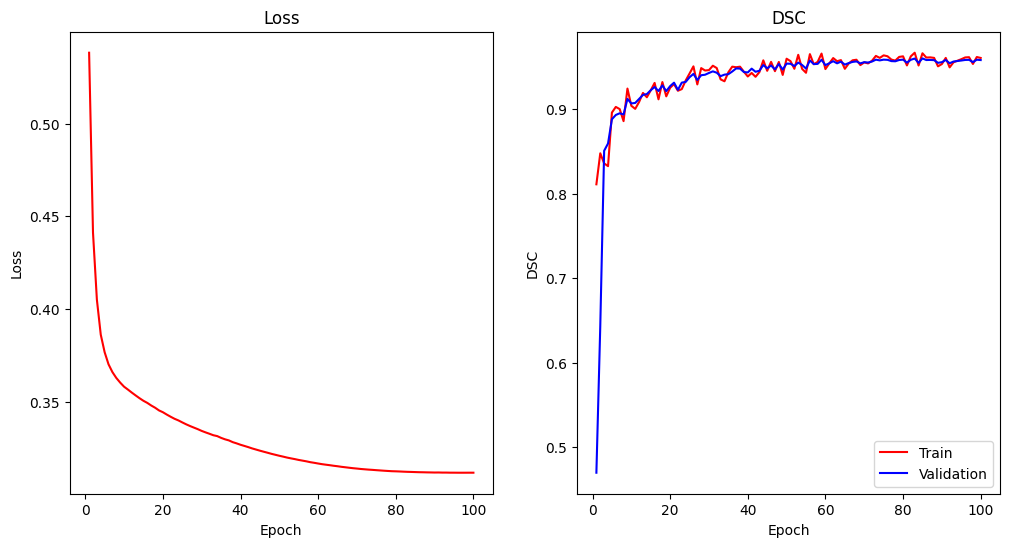

In [19]:
total_time = time.time() - total_start
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")
logger.info(
    f"best_metric: {best_metric:.4f} at epoch {best_metric_epoch}, "
    f"total time to train: {total_time}"
    )

fig = plt.figure("Performance in training", (12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
ax1.plot(x, y, color="red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("DSC")
x1 = [i + 1 for i in range(len(epoch_loss_values))]
x2 = [val_interval * (i + 1) for i in range(len(metric_values))]
y1 = epoch_metric_values
y2 = metric_values
ax2.plot(x1, y1, color="red")
ax2.plot(x2, y2, color="blue")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("DSC")
ax2.legend(["Train","Validation"])
plt.savefig(os.path.join(root_dir, "performance.tif"))
plt.show

## Check the best model output with the input image and label

<function matplotlib.pyplot.show(close=None, block=None)>

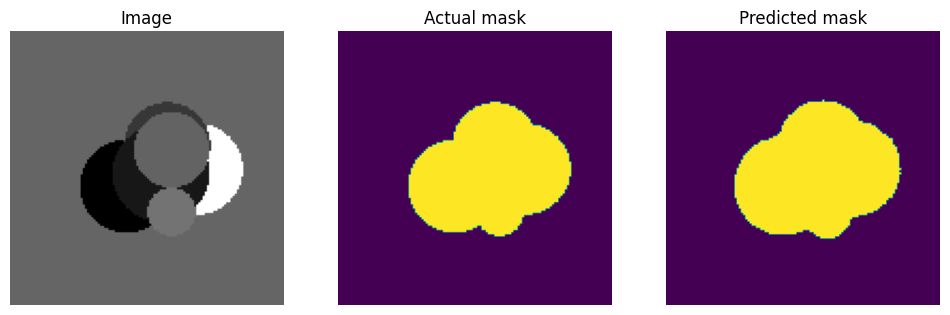

In [20]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # Select one image to evaluate and visualize the model output
    val_input = val_ds[6][0].unsqueeze(0).to(device)
    val_output = model(val_input)
    val_output = post_pred(val_output[0])

fig = plt.figure("Actual vs. Predicted", (12, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Image")
ax1.imshow(val_ds[6][0][0,:, :, 70].detach().cpu(), cmap="gray")
ax1.axis('off')
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("Actual mask")
ax2.imshow(val_ds[6][1][0,:, :, 70].detach().cpu())
ax2.axis('off')
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("Predicted mask")
ax3.imshow(val_output[0,:, :, 70].detach().cpu())
ax3.axis('off')
plt.savefig(os.path.join(root_dir, "actual_predicted.tif"))
plt.show